## Data preprosesing

### Identify missing values
Convert <b>"?"</b> to NaN and rename columnn for great convenience.

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from tabulate import tabulate

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

raw_data = pd.read_csv('dataset/VehicleDataset.csv')
raw_data.columns = [column.lower().replace("-", "_").replace(" ", "_") for column in raw_data.columns]

df=raw_data.copy()
df.replace('?', np.nan, inplace = True)

C:\Users\garik\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Check count messing value in each column
Each column has 205 rows of data and 7 columns containing missing data:

1) <b> normalize losses </b>: 41 missing data
2) <b>num of doors</b> : 2 missing data
3) <b>bore</b> : 4 missing data
4) <b>stroke</b> : 4 missing data
5) <b>horsepower</b> : 2 missing data
6) <b>peak rpm</b> : 2 missing data
7) <b>price</b>  : 4 missing data

In [3]:
def describe_(df):
    missing_data = df.isnull()

    data_isnotnull = [df[column][df[column] != np.nan].count() for column in df.columns]
    data_null = [max(data_isnotnull)-value for value in data_isnotnull]
    
    data = np.array([missing_data.columns, df.dtypes.values, data_isnotnull, data_null], dtype=str)
    headers= ["Name","Type","No Null", "Null"]
    
    print(tabulate(data.T, headers=headers))

In [4]:
describe_(df)

Name               Type       No Null    Null
-----------------  -------  ---------  ------
symboling          int64          205       0
normalized_losses  object         164      41
make               object         205       0
fuel_type          object         205       0
aspiration         object         205       0
num_of_doors       object         203       2
body_style         object         205       0
drive_wheels       object         205       0
engine_location    object         205       0
wheel_base         float64        205       0
length             float64        205       0
width              float64        205       0
height             float64        205       0
curb_weight        int64          205       0
engine_type        object         205       0
num_of_cylinders   object         205       0
engine_size        int64          205       0
fuel_system        object         205       0
bore               object         201       4
stroke             object         

### Data analysis 
<ul>
<li><b>84.04%</b> Sedan is four doors.<br>
    It was reasonable if missed data for the number of doors will be replace by four.<br></li>
    <li>Missed data with <b>natural numbers</b> can be replace by <b>mean</b> value whole column. </li>
    <li>Missed price data will be deleted, because price is what we want predict. Any data entry without price data cannot be used for prediction.</li>
</ul>

In [5]:
print(raw_data.loc[:,["num_of_doors", "body_style"]].groupby("body_style").value_counts(), 
      "\n{}% sedan is four doors.".format(round(79/(79+15)*100,2)))

body_style   num_of_doors
convertible  two              6
hardtop      two              8
hatchback    two             60
             four            10
sedan        four            79
             two             15
             ?                2
wagon        four            25
dtype: int64 
84.04% sedan is four doors.


### Replace missing values or drop value
<b>Replace by avg value:</b>
<ul>
    <li><b>normalized losses</b> : 41 missing data, replace them with mean</li>
    <li><b>stroke</b> : 4 missing data, replace them with mean</li>
    <li><b>bore</b> : 4 missing data, replace them with mean</li>
    <li><b>horsepower</b> : 2 missing data, replace them with mean</li>
    <li><b>peak-rpm</b> : 2 missing data, replace them with mean</li>
</ul>

<b>Replace by frequency:</b>
<ul>
    <li><b>num of doors</b> : 2 missing data, replace them with "four". 
    </li>
</ul>

<b>Drop the whole 4 rows:</b>
<ul>
    <li><b>price</b> : 4 missing data, simply delete the whole row</li>
</ul>

#### Delete 4-rows price 

In [27]:
df.dropna(subset=["price"],axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)

#### Replace and Convert

In [28]:
def Calculate_Mean(df, сolumns):
    for index, column in enumerate(сolumns):
        avg_value = df[column].astype("float").mean(axis=0)
        print("Average of {} : {}".format(column.replace("_", " "), round(avg_value,2)))
        df[column].replace(np.nan, avg_value, inplace=True)
    return df


def Convert_Type(df, columns, type_):
    for index, column in enumerate(columns):
        df[column] = df[column].astype(type_[index])
    return df


def Count_labels(df, titles):
    for title in titles:
        print(title)
        df[title] = LabelEncoder().fit_transform(df[title].values)
    return df

In [29]:
df.num_of_doors.replace(np.nan,"four",inplace=True)
df = Calculate_Mean(df, ["normalized_losses", "bore", "stroke", "horsepower", "peak_rpm"])
df = Convert_Type(df, ["normalized_losses", "bore", "stroke", "horsepower", "peak_rpm", "price"], [int, float, float, int, int, float])
df_tr = df.copy()
df_tr = Count_labels(df_tr, df_tr.select_dtypes(include='object').columns)

Average of normalized losses : 122.0
Average of bore : 3.33
Average of stroke : 3.26
Average of horsepower : 103.39
Average of peak rpm : 5117.58
make
size_group
fuel_type
aspiration
num_of_doors
body_style
drive_wheels
engine_location
engine_type
num_of_cylinders
fuel_system


#### Quantile

In [30]:
df_tr = df_tr[df_tr.price < df_tr.price.quantile(0.9)]

#### Out

In [31]:
describe_(df)

Name               Type       No Null    Null
-----------------  -------  ---------  ------
symboling          int64          201       0
normalized_losses  int32          201       0
make               object         201       0
size_group         object         201       0
fuel_type          object         201       0
aspiration         object         201       0
num_of_doors       object         201       0
body_style         object         201       0
drive_wheels       object         201       0
engine_location    object         201       0
wheel_base         float64        201       0
length             float64        201       0
width              float64        201       0
height             float64        201       0
curb_weight        int64          201       0
engine_type        object         201       0
num_of_cylinders   object         201       0
engine_size        int64          201       0
fuel_system        object         201       0
bore               float64        

In [32]:
df_tr.head()
df_tr.describe()

,symboling,normalized_losses,make,size_group,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.0,...,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,0.888889,122.505556,12.683333,2.138889,0.916667,0.161111,0.433333,2.644444,1.261111,0.0,...,116.988889,3.111111,3.302905,3.244820,9.969000,96.388889,5135.466667,26.055556,31.716667,10975.461111
std,1.227656,33.230110,6.207290,0.666550,0.277156,0.368659,0.496918,0.823009,0.532349,0.0,...,25.696116,2.057522,0.260949,0.307184,3.718489,30.115122,465.764577,6.115026,6.342439,4253.337164
min,-2.000000,65.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,61.000000,0.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,16.000000,22.000000,5118.000000
25%,0.000000,101.000000,8.000000,2.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.0,...,97.000000,1.000000,3.150000,3.117500,8.675000,70.000000,4800.000000,21.000000,27.000000,7607.500000
50%,1.000000,122.000000,13.000000,2.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.0,...,110.000000,3.000000,3.270000,3.280000,9.000000,92.000000,5200.000000,25.500000,31.000000,9594.000000
75%,2.000000,148.000000,19.000000,3.000000,1.000000,0.000000,1.000000,3.000000,2.000000,0.0,...,134.000000,5.000000,3.540000,3.410000,9.400000,112.000000,5500.000000,31.000000,37.000000,13882.500000
max,3.000000,256.000000,21.000000,3.000000,1.000000,1.000000,1.000000,4.000000,2.000000,0.0,...,181.000000,7.000000,3.940000,3.900000,23.000000,200.000000,6600.000000,49.000000,54.000000,22018.000000


## Data normalization

### Add group-size column

In [33]:
def range_category(lower: float, upper: float, key):
    return lower <= key <= upper

def in_ft(value):
    return value * 0.083333

def GROUP_SIZE_CAR(curb_weight:float, S: float):
    if range_category(1400,2500,curb_weight) and range_category(55,80, S): return 'mini-size'
    if range_category(2001,2500,curb_weight) and range_category(80.0001,110, S): return 'small-size'
    if range_category(2001,2500,curb_weight) and range_category(110.0001,200, S): return 'medium-size'

    if range_category(2501,4000,curb_weight) and range_category(70,80, S): return 'small-size'
    if range_category(2501,3000,curb_weight) and range_category(80.0001,90, S): return 'small-size'
    if range_category(2501,3000,curb_weight) and range_category(90.0001,200, S): return 'medium-size'

    if range_category(3001,8000,curb_weight) and range_category(80.0001,90, S): return 'medium-size'
    if range_category(3001,3500,curb_weight) and range_category(90.0001,100, S): return 'medium-size'
    if range_category(3001,3500,curb_weight) and range_category(100.0001,200, S): return 'big-size'
    
    if range_category(3501,4000,curb_weight) and range_category(90.0001,110, S): return 'big-size'
    if range_category(3501,4000,curb_weight) and range_category(110.0001,200, S): return 'very-big-size'

    if range_category(4000,8000,curb_weight) and range_category(70,80, S): return 'medium-size'
    if range_category(4000,8000,curb_weight) and range_category(90.0001,100, S): return 'big-size'
    if range_category(4000,8000,curb_weight) and range_category(100.0001,200, S): return 'very-big-size'
    else:
        print(curb_weight, S)
    return 0

size = [GROUP_SIZE_CAR(curb_weight, in_ft(l)*in_ft(w)) for curb_weight, l, w in zip(df.curb_weight.to_list(), df.length.to_list(), df.width.to_list())]
df.insert(3, "size_group", size)

ValueError: cannot insert size_group, already exists

### Descriptive Statistical Analysis

In [35]:
from scipy.stats import pearsonr, f_oneway
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold

In [36]:
def udf_pearsonr(X, y): 
    result = np.array([pearsonr(x, y) for x in X.T])
    return np.absolute(result[:,0]), result[:,1] 

def organize(data, titles:[], target='price'):
    set_x = data.loc[:,titles]
    y = set_x[target]
    set_x = set_x.drop(target, axis=1)
    return np.array(set_x.values.tolist()),y.values.tolist()

selector = SelectKBest(udf_pearsonr, k=2)
selector_varianceThreshold = VarianceThreshold(0.25)

In [37]:

selected_data = selector_varianceThreshold.fit_transform(df_tr)
title_features = selector_varianceThreshold.get_feature_names_out(df_tr.columns)

X, y = organize(df_tr, title_features)

train_set = X
train_y = y
display(len(title_features))

21

In [38]:
for idx in range(train_set.shape[1]):
    title = title_features[idx].replace("_", " ").capitalize()
    pea_score, p_value = pearsonr(train_set[:,idx], train_y)
    print(f"{title} feature vs Price is {round(np.abs(pea_score),3)}, p-value is {p_value}".format())

Symboling feature vs Price is 0.036, p-value is 0.6331842154850545
Normalized losses feature vs Price is 0.317, p-value is 1.4352759788069227e-05
Make feature vs Price is 0.005, p-value is 0.9465789197062073
Size group feature vs Price is 0.07, p-value is 0.3498586884922456
Body style feature vs Price is 0.085, p-value is 0.25421650817357294
Drive wheels feature vs Price is 0.565, p-value is 1.5008084787375338e-16
Wheel base feature vs Price is 0.612, p-value is 7.210669291835463e-20
Length feature vs Price is 0.716, p-value is 1.3237649365440924e-29
Width feature vs Price is 0.745, p-value is 4.483940735629761e-33
Height feature vs Price is 0.187, p-value is 0.012055937204577285
Curb weight feature vs Price is 0.838, p-value is 1.3532161301065677e-48
Engine type feature vs Price is 0.053, p-value is 0.4819564774757745
Num of cylinders feature vs Price is 0.155, p-value is 0.03756021162069747
Engine size feature vs Price is 0.725, p-value is 1.1540207363299491e-30
Fuel system feature v

### Visual

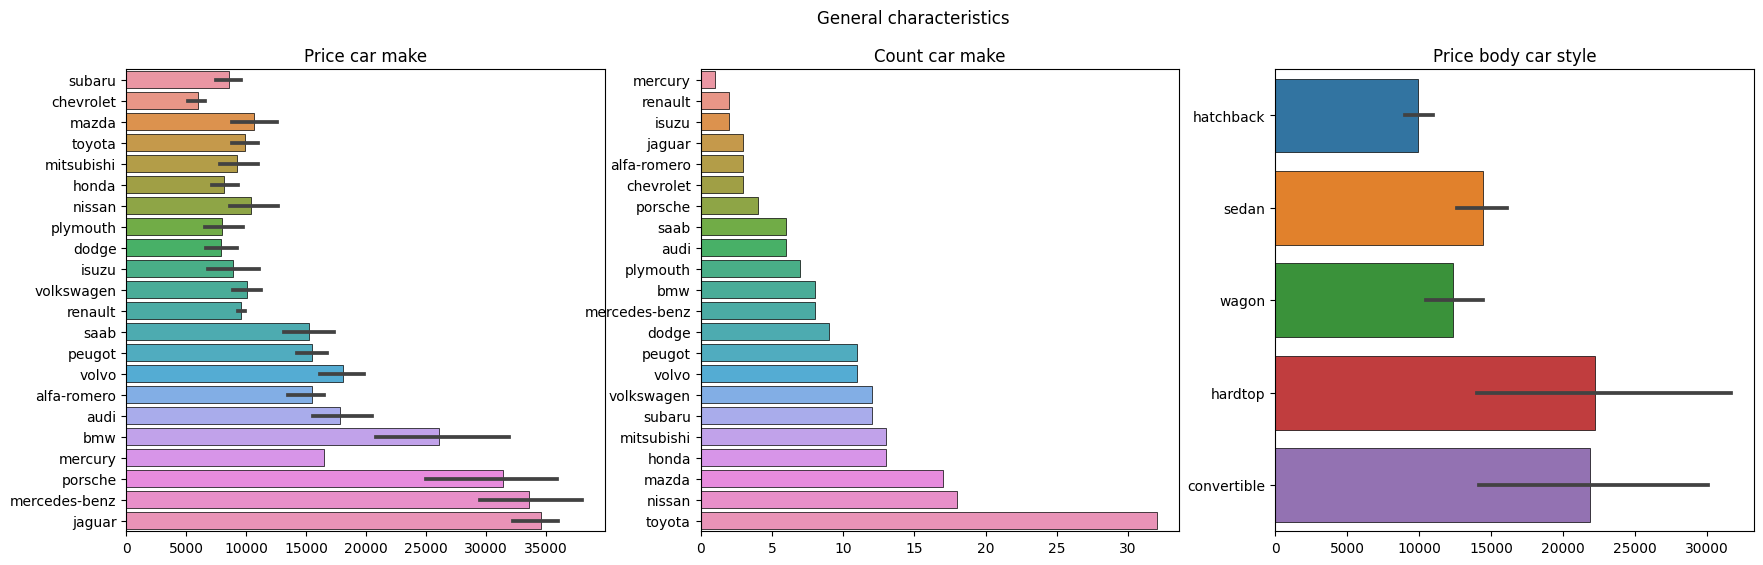

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

sns.barplot(data=df.sort_values(["price"]),
            ax=axes[0],y="make",x="price",edgecolor="black",linewidth=0.5)
sns.barplot(data=df.groupby(["make"], as_index=False).count().sort_values(["price"]),
            ax=axes[1],y="make",x="price",edgecolor="black",linewidth=0.5,)
sns.barplot(data=df.sort_values(["price"]), 
            ax=axes[2],y="body_style", x="price",edgecolor="black",linewidth=0.5)
axes[0].set(title="Price car make", xlabel=None, ylabel=None)
axes[1].set(title="Count car make", xlabel=None, ylabel=None)
axes[2].set(title="Price body car style", xlabel=None, ylabel=None)

title = "General characteristics"
plt.rc('ytick', labelsize=8)
plt.rc('xtick', labelsize=8)
fig.suptitle(title)
plt.savefig('img/{}.jpg'.format(title))

In [160]:
clf = RandomForestRegressor(n_estimators = 50, random_state = 123)
clf.fit(X, y)
sorted(np.round(clf.feature_importances_, 4), reverse=True)

[0.5897,
 0.1564,
 0.0632,
 0.0334,
 0.0292,
 0.0189,
 0.0181,
 0.0175,
 0.0127,
 0.0119,
 0.0104,
 0.0081,
 0.0081,
 0.0058,
 0.0056,
 0.0054,
 0.0025,
 0.0018,
 0.0012]

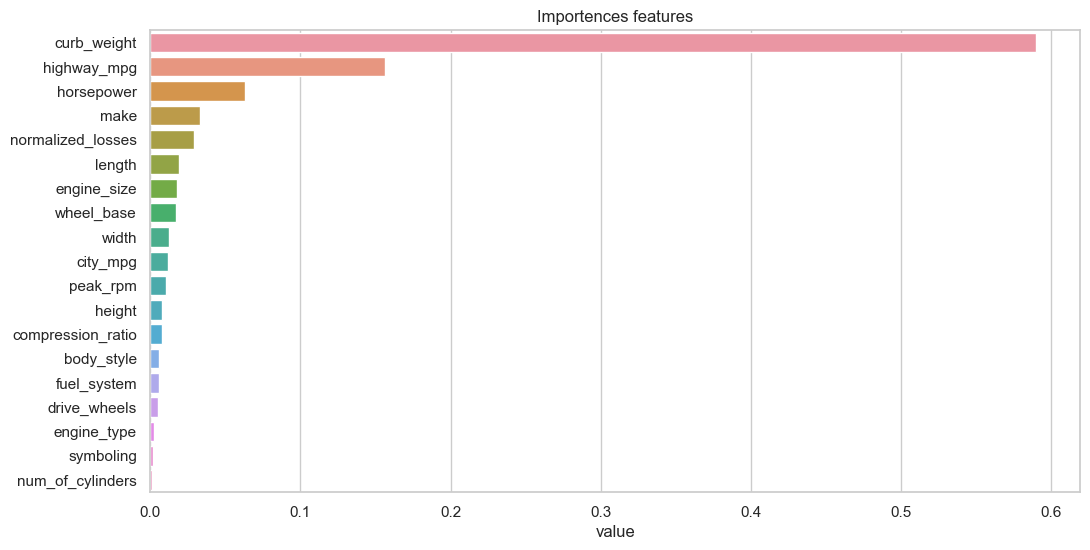

In [216]:
fig, ax=plt.subplots(figsize=(12,6))
importances = clf.feature_importances_
indices =np.argsort(importances)
title="Importences features"
importences_features = pd.DataFrame(data={"value":importances, "title":np.array(title_features)[range(len(indices))]})
sns.barplot(data=importences_features.sort_values("value",ascending=False ), x="value", y="title")
ax.set(ylabel=None, title=title)
plt.savefig('img/{}.jpg'.format(title))

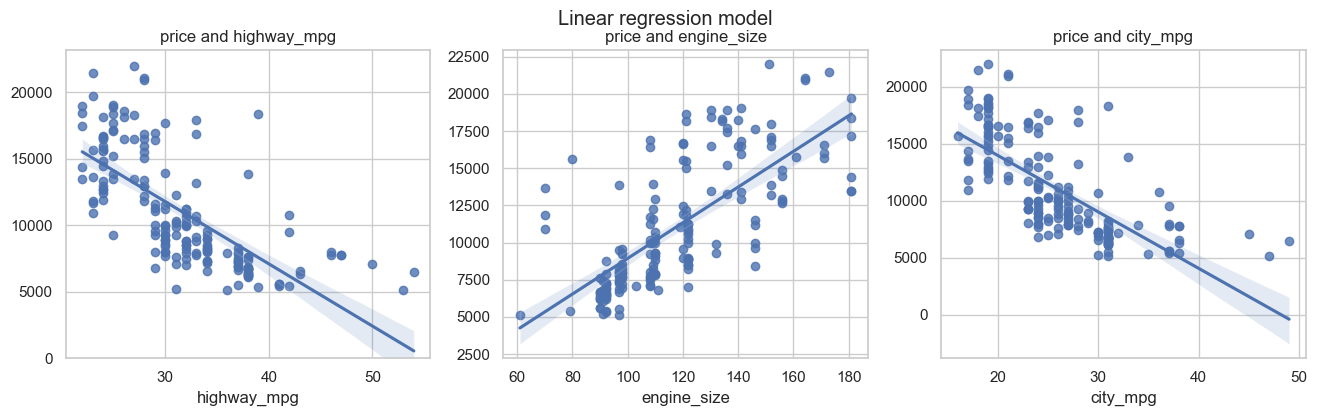

In [49]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1,3, figsize=(16,4))
sns.regplot(x="highway_mpg", y="price", data=df_tr, ax=axes[0]).set(ylim=(0))
sns.regplot(x="engine_size", y="price", data=df_tr, ax=axes[1])
sns.regplot(x="city_mpg", y="price", data=df_tr, ax=axes[2])

axes[0].set(title="price and highway_mpg" , ylabel=None)
axes[1].set(title="price and engine_size" , ylabel=None)
axes[2].set(title="price and city_mpg", ylabel=None)

title="Linear_regression_model"
fig.suptitle(title.replace("_", " "))
plt.savefig('img/{}.jpg'.format(title))

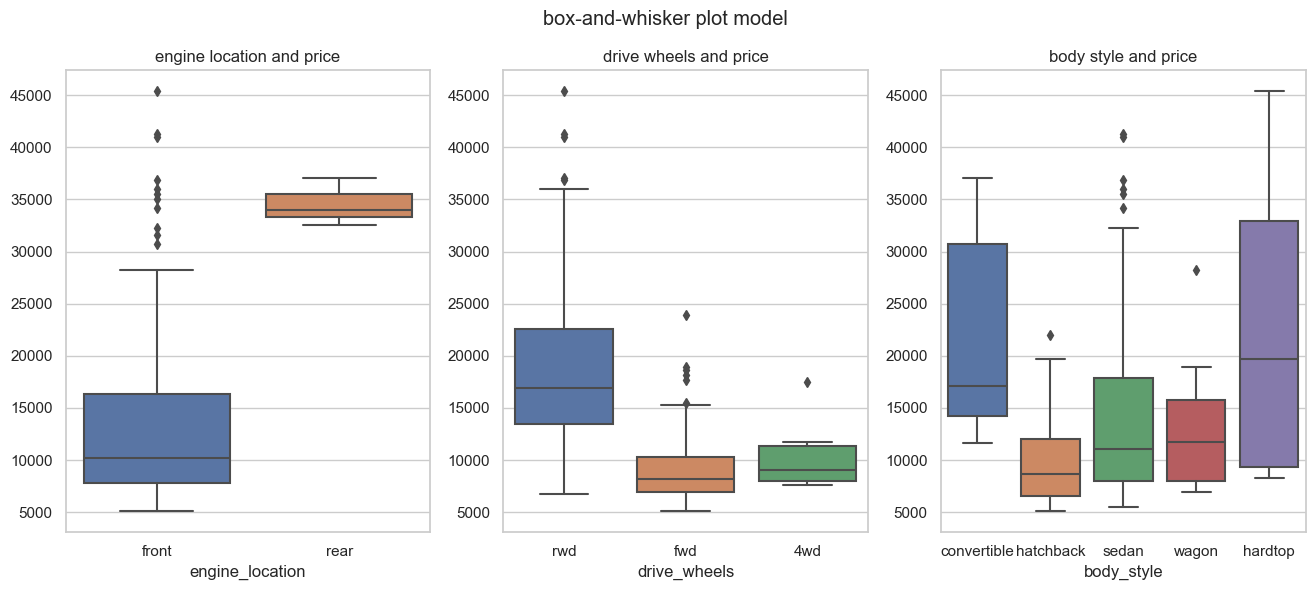

In [50]:
fig, axes = plt.subplots(1,3, figsize=(16,6))
sns.boxplot(x="engine_location", y="price", data=df, ax=axes[0])
sns.boxplot(x="drive_wheels", y="price", data=df, ax=axes[1])
sns.boxplot(x="body_style", y="price", data=df, ax=axes[2])

axes[0].set(title="engine location and price" , ylabel=None)
axes[1].set(title="drive wheels and price" , ylabel=None)
axes[2].set(title="body style and price", ylabel=None)

title="box-and-whisker_plot_model"
fig.suptitle(title.replace("_", " "))
plt.savefig('img/{}.jpg'.format(title))

In [45]:
grouped_df = df.loc[:,["price","engine_type","body_style"]].groupby(["engine_type","body_style"],as_index=False).mean().sort_values(["price"])
grouped_pivot = grouped_df.pivot(index='engine_type',columns='body_style')
grouped_pivot

price                                                   
body_style  convertible  hardtop     hatchback         sedan         wagon
engine_type                                                               
dohc            14997.5      NaN  15061.000000  22281.600000  15750.000000
l                   NaN      NaN   5151.000000  15758.571429  15017.500000
ohc             14632.0  13142.4   9001.153846  13134.070423  12114.133333
ohcf            37028.0  33278.0   6591.333333   9070.600000   9342.000000
ohcv            35056.0  45400.0  17949.250000  26604.500000  14399.000000
rotor               NaN      NaN  13020.000000           NaN           NaN

In [46]:
grouped_pivot = grouped_pivot.fillna(0) #fill missing values with 0
grouped_pivot

price                                                   
body_style  convertible  hardtop     hatchback         sedan         wagon
engine_type                                                               
dohc            14997.5      0.0  15061.000000  22281.600000  15750.000000
l                   0.0      0.0   5151.000000  15758.571429  15017.500000
ohc             14632.0  13142.4   9001.153846  13134.070423  12114.133333
ohcf            37028.0  33278.0   6591.333333   9070.600000   9342.000000
ohcv            35056.0  45400.0  17949.250000  26604.500000  14399.000000
rotor               0.0      0.0  13020.000000      0.000000      0.000000

[Text(0.5, 0, 'convertible'),
 Text(1.5, 0, 'hatchback'),
 Text(2.5, 0, 'sedan'),
 Text(3.5, 0, 'wagon'),
 Text(4.5, 0, 'hardtop')]

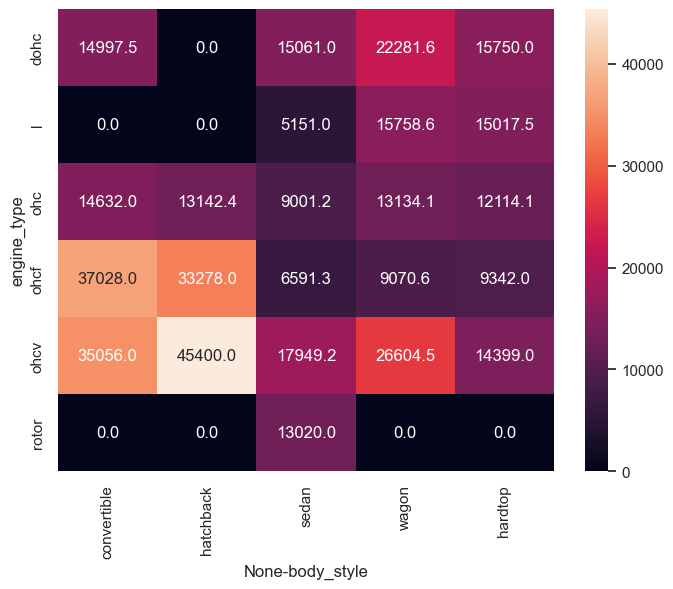

In [47]:
fig, axes = plt.subplots(figsize=(8,6))
sns.heatmap(grouped_pivot, annot=True, fmt=".1f")
axes.set_xticklabels(labels=df.body_style.unique(), rotation=90)

In [41]:
def set_pivot(index:str, column:str):
    grouped_df = df.loc[:,["price",index,column]].groupby([index,column],as_index=False).mean().sort_values([column])
    grouped_pivot = grouped_df.pivot(index=index,columns=column)
    return grouped_pivot.fillna(0)

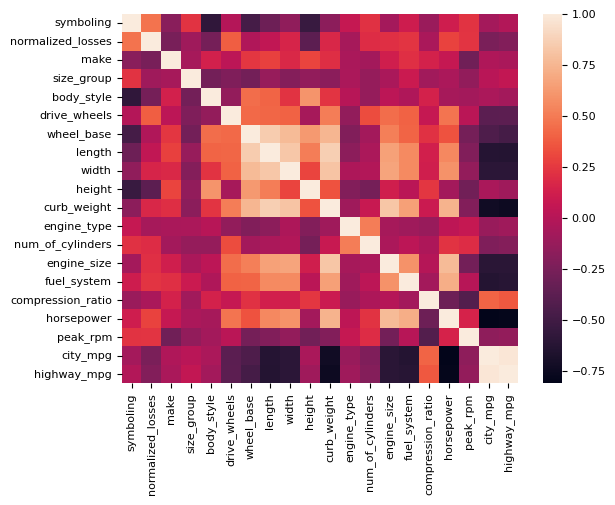

In [44]:
fig, ax = plt.subplots()
cln_date = df_tr[title_features]
correlation = cln_date.drop(["price"], axis=1).corr(min_periods=3)
correlation.set_index(correlation.columns, inplace=True)
correlation.to_csv('result_correlation.csv', encoding='utf-8', index=True)

sns.heatmap(correlation, ax=ax)
plt.savefig('img/{}.jpg'.format("result_correlation"))